In [1]:
import os
import io
import pandas as pd
import tensorflow as tf
from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [2]:
def class_text_to_int(row_label):
    if row_label == 'fruit_healthy':
        return 1
    elif row_label == 'fruit_woodiness':
        return 2
    elif row_label == 'fruit_brownspot':
        return 3
    else:
        return None

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def generate_files(df, image_path, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    grouped = split(df, 'filename')
    for group in grouped:
            tf_example = create_tf_example(group, image_path)
            writer.write(tf_example.SerializeToString())
    writer.close()
    print('Successfully created the TFRecords: {}'.format(output_path))

In [3]:
train_image_path, val_image_path = '../../Train_Images/', '../../Val_Images/'
df = pd.read_csv('../../Train.csv')
df['xmax'] = df['xmin'] + df['width']
df['ymax'] = df['ymin'] + df['height']
df['filename'] = df['Image_ID'] + '.jpg'

df['is_train'] = df.Image_ID.map(lambda x: os.path.exists(f'{train_image_path}{x}.jpg'))

df_train, df_val = df[df.is_train == True].reset_index(drop=True), df[df.is_train == False].reset_index(drop=True)
assert df_train.filename.nunique() == len([x for x in os.listdir(train_image_path) if x[-3:] == 'jpg'])
assert df_val.filename.nunique() == len([x for x in os.listdir(val_image_path) if x[-3:] == 'jpg'])
print(f"Total Train Images: {df_train.filename.nunique()}\nTotal Val Images: {df_val.filename.nunique()}")

Total Train Images: 2698
Total Val Images: 303


In [4]:
train_record_path, val_record_path = './train.record', './val.record'
generate_files(df_train, train_image_path, train_record_path)
generate_files(df_val, val_image_path, val_record_path)

Successfully created the TFRecords: ./train.record
Successfully created the TFRecords: ./val.record


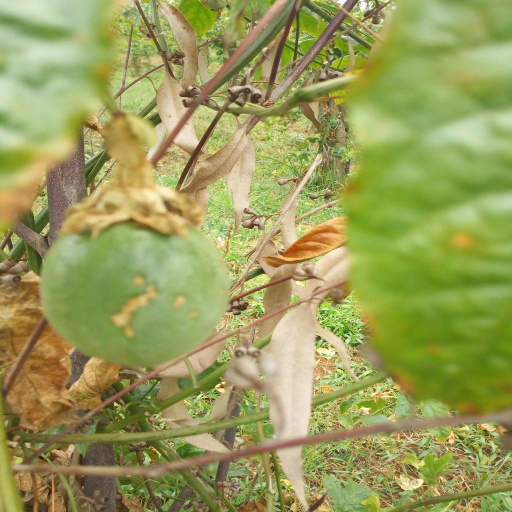

In [24]:
import numpy as np

raw_dataset = tf.data.TFRecordDataset(val_record_path)

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
result = {}
# example.features.feature is the dictionary
for key, feature in example.features.feature.items():
    kind = feature.WhichOneof('kind')
    result[key] = np.array(getattr(feature, kind).value)
    
encoded_jpg_io = io.BytesIO(result['image/encoded'])
Image.open(encoded_jpg_io)